In [1]:
# path to Mendel docs: /Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/data

In [2]:
# path to Mendel manifest: /Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/manifest

In [123]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [44]:
data_dir = Path("/Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/data/mendel_output")
manifest_dir = Path("/Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/manifest/mendel_output")

In [77]:
our_results_dir = Path("/Users/cpan/Desktop/Entities_compare")

In [19]:
pwd

'/Users/cpan/Desktop'

In [70]:
def load_data_output(data_dir, folder_name):
    data_lst = []
    folder = data_dir / folder_name
    if folder.exists() and folder.is_dir(): 
        json_files = list(folder.glob('*.json')) 
        
        for json_file in json_files: 
            with open(json_file, 'r') as file: 
                for line in file:
                    json_data = json.loads(line)  # Load each line as a separate JSON object
                    data_lst.append(json_data)
    else:
        print("The folder does not exist")
    return data_lst

def load_json_our_results(file_name):
    file_path = our_results_dir / file_name
    with open(file_path, 'r') as file:
        json_data = json.load(file)
        
    json_data_df = pd.DataFrame(json_data)
    return json_data_df

In [43]:
breast_data = load_data_output(data_dir, 'breast')

In [47]:
breast_data_manifest = load_data_output(manifest_dir, 'breast')

In [48]:
print(len(breast_data))
print(len(breast_data_manifest))

3895
149


In [49]:
breast_data[0]

{'patient_id': 'pt-01h5b98ydzgcrxhz9cmsbb20x1',
 'event_id': 'evt-01h6pe0bfra5e5eyja8085z0p6',
 'event_type': 'Biomarker',
 'endpoint_name': 'Biomarker',
 'confidence_score': 0.448987156152725,
 'property_type': 'Biomarker Tested',
 'property_value_type': 'Concept',
 'concept_values': [{'concept_name': 'TP53', 'mendel_cid': '240361'}],
 'property_evidences': [{'document_id': 'doc-01h5dxcjq4fnkcba9d3zh4zj5x',
   'mention': 'TP53',
   'start_char': 1046,
   'end_char': 1050}]}

In [50]:
breast_data_manifest[0]

{'mendel_patient_id': 'pt-01h5b98ydzgcrxhz9cmsbb20x1',
 'customer_patient_id': 'A0586396',
 'resolve_path': 's3://mendel-guardant-data/outbound/073123/data/mendel_output/breast/pt-01h5b98ydzgcrxhz9cmsbb20x1.json',
 'tenant_num': 1,
 'tenant_domain': 'https://gdt1-api-sandbox.mendel.ai/v1/',
 'site_name': 'guardant'}

In [60]:
def create_matched_dataframe(data, manifest):
    # Create DataFrames from the lists
    data_df = pd.DataFrame(data)
    manifest_df = pd.DataFrame(manifest)
    
    # Merge the DataFrames based on 'patient_id' and 'mendel_patient_id'
    merged_df = pd.merge(data_df, manifest_df,
                         left_on='patient_id', right_on='mendel_patient_id')
    
    # Extract 'mention' from 'property_evidences' list of dictionaries
    merged_df['mention'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['mention'] if isinstance(x, list) and len(x) > 0 else None)
    
    # Extract all concept names from 'concept_values' lists
    merged_df['all_concept_names'] = merged_df['concept_values'].apply(
        lambda x: ', '.join([c['concept_name'] for c in x]) if isinstance(x, list) else None)
    
    # Extract 'document_id', 'start_char', and 'end_char' for the corresponding 'mention'
    merged_df['document_id'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['document_id'] if isinstance(x, list) and len(x) > 0 else None)
    merged_df['start_char'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['start_char'] if isinstance(x, list) and len(x) > 0 else None)
    merged_df['end_char'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['end_char'] if isinstance(x, list) and len(x) > 0 else None)
    
    # Select the desired columns
    selected_columns = ['customer_patient_id', 'event_type', 'confidence_score', 
                        'property_type', 'property_value_type', 'mention', 'all_concept_names',
                        'document_id', 'start_char', 'end_char']
    
    # Create the final DataFrame with selected columns
    final_df = merged_df[selected_columns].copy()
    
    return final_df

In [61]:
breast_mendel_df = create_matched_dataframe(breast_data, breast_data_manifest)

In [62]:
breast_mendel_df.head()

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char
0,A0586396,Biomarker,0.448987,Biomarker Tested,Concept,TP53,TP53,doc-01h5dxcjq4fnkcba9d3zh4zj5x,1046.0,1050.0
1,A0586396,Biomarker,0.448987,Categorical Value,Concept,F328,Gene Mutation,doc-01h5dxcjq4fnkcba9d3zh4zj5x,2727.0,2731.0
2,A0586396,Biomarker,0.448987,Numeric Value,String,0.7 %\n,None,doc-01h5dxcjq4fnkcba9d3zh4zj5x,1073.0,1079.0
3,A0586396,Biomarker,0.448987,Date of Result,String,OCT-11-2022,None,doc-01h5dxcjq4fnkcba9d3zh4zj5x,297.0,308.0
4,A0586396,Biomarker,0.448987,Method of Testing,Concept,sequenced using the illumina platform,Next Generation Sequencing,doc-01h5dxcjq4fnkcba9d3zh4zj5x,7021.0,7058.0


In [78]:
# load our results 
breast_our_df = load_json_our_results('breast_cancer_174_docs_entities.json')

In [79]:
breast_our_df.head()

,file_name,dates,important dates,diseases,smoking,smoking_keyword,ecogs,test_results
0,A0644526_MedRec1.txt,"[{'start': 2, 'end': 12, 'text': '23/01/2712',...",[],"[{'start': 304, 'end': 317, 'text': 'chest abd...",no,,[],[]
1,A0650073_MedRec1.txt,"[{'start': 2021, 'end': 2031, 'text': '10/14/2...",[{'keyword': 'received lbrance. feels better. ...,"[{'start': 355, 'end': 373, 'text': 'malignant...",no,,"[{'start': 5103, 'end': 5121, 'text': 'perform...","[{'test_name': 'estrogen receptor', 'test_valu..."
2,A0640703_MedRec1.txt,"[{'start': 3027, 'end': 3037, 'text': '12/12/2...",[],"[{'start': 199, 'end': 214, 'text': 'birth: 3/...",no,no smoking,"[{'start': 7009, 'end': 7027, 'text': 'perform...",[]
3,A0635794_MedRec1.txt,"[{'start': 228, 'end': 238, 'text': '12/22/202...",[],"[{'start': 703, 'end': 714, 'text': 'breast ma...",yes,smoking,[],"[{'test_name': 'estrogen receptor', 'test_valu..."
4,A0635794_MedRec2.txt,"[{'start': 56312, 'end': 56322, 'text': '42/15...",[{'keyword': 'collection date: deg-22-2022 ne ...,"[{'start': 147, 'end': 177, 'text': 'braaat ca...",yes,smoking,"[{'start': 11248, 'end': 11259, 'text': 'perfo...","[{'test_name': 'hormone receptor', 'test_value..."


In [227]:
breast_our_df.iloc[1]['test_results']

[{'test_name': 'estrogen receptor', 'test_value': 'negative'},
 {'test_name': 'estrogen receptor', 'test_value': 'negative'},
 {'test_name': 'estrogen receptor', 'test_value': 'negative'},
 {'test_name': 'estrogen receptor', 'test_value': 'negative'},
 {'test_name': 'estrogen receptor', 'test_value': 'negative'}]

### Data Analysis 
- breast cancer data 

In [81]:
# Display basic information about the DataFrame
print(breast_mendel_df.info())
# Summary statistics for numeric columns
print(breast_mendel_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3895 entries, 0 to 3894
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_patient_id  3895 non-null   object 
 1   event_type           3895 non-null   object 
 2   confidence_score     803 non-null    float64
 3   property_type        3895 non-null   object 
 4   property_value_type  3877 non-null   object 
 5   mention              3877 non-null   object 
 6   all_concept_names    2915 non-null   object 
 7   document_id          3877 non-null   object 
 8   start_char           3877 non-null   float64
 9   end_char             3877 non-null   float64
dtypes: float64(3), object(7)
memory usage: 334.7+ KB
None
       confidence_score    start_char      end_char
count        803.000000   3877.000000   3877.000000
mean           0.708991   6751.015476   6760.712149
std            0.197492   8678.684302   8679.320616
min            0.278779   

In [290]:
def create_colorful_bar_plot(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x_col, y=y_col, data=data, palette="viridis")
    plt.title(title)
    plt.xticks(rotation=45)
    
    # Display actual counts on the bars
    for index, value in enumerate(y_col):
        plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10, color='black')
    
    plt.show()

# Function to create a colorful box plot
def create_colorful_box_plot(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data, palette="plasma")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_top_concept_counts(data_df, column_name, top_n=20):
    concept_counts = data_df[column_name].value_counts()[:top_n]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=concept_counts.index, y=concept_counts.values, palette="viridis")
    plt.xticks(rotation=90)
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.title(f"Breast Cancer Top {top_n} {column_name} Counts")
    for i, count in enumerate(concept_counts.values):
        plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

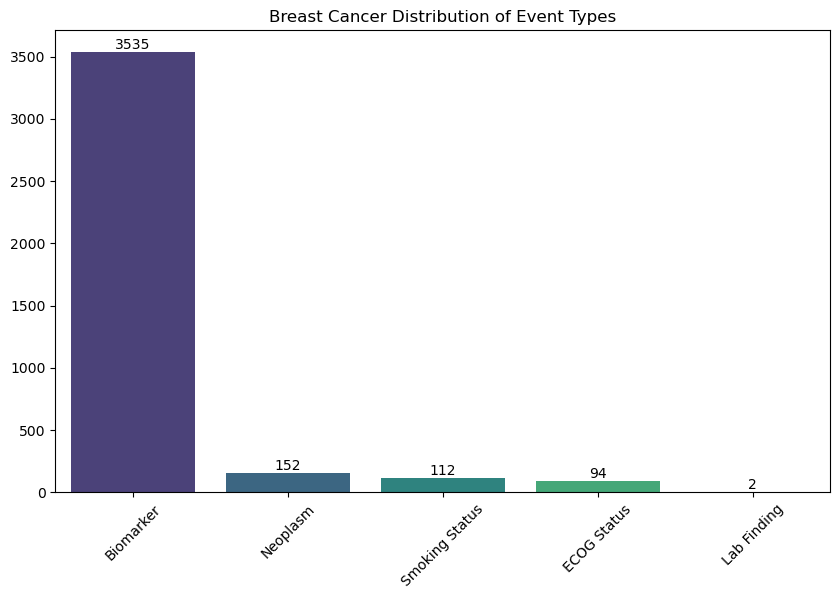

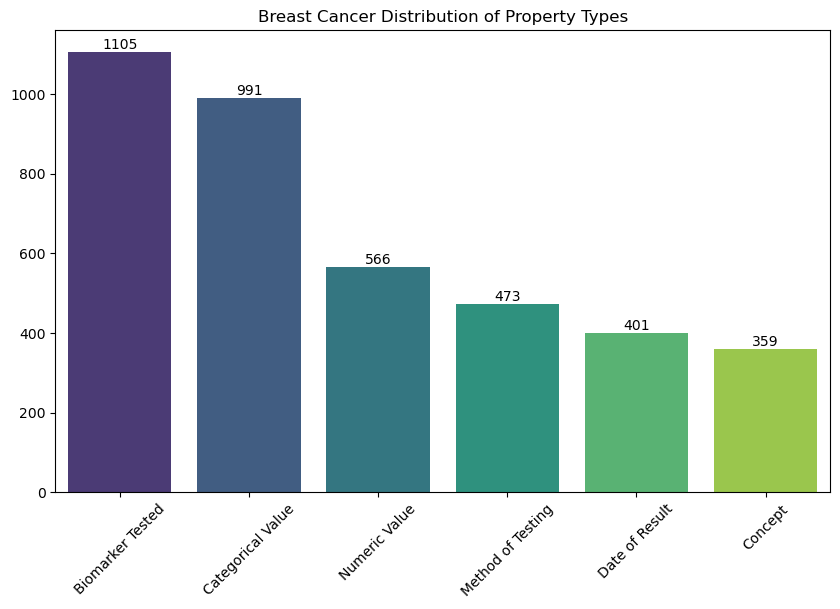

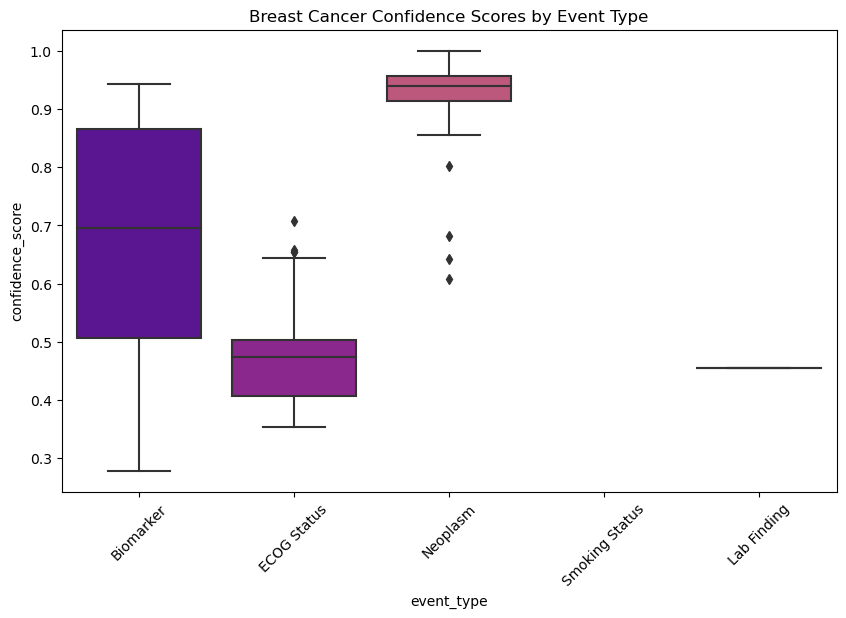

In [284]:
# Distribution of event types
event_type_counts = breast_mendel_df['event_type'].value_counts()
create_colorful_bar_plot(breast_mendel_df, event_type_counts.index, event_type_counts.values, 'Breast Cancer Distribution of Event Types')

# Distribution of property types
property_type_counts = breast_mendel_df['property_type'].value_counts()
create_colorful_bar_plot(breast_mendel_df, property_type_counts.index, property_type_counts.values, 'Breast Cancer Distribution of Property Types')

# Box plot of confidence scores by event type
create_colorful_box_plot(breast_mendel_df, 'event_type', 'confidence_score', 'Breast Cancer Confidence Scores by Event Type')

In [98]:
print(len(breast_mendel_df['all_concept_names'].unique()))
breast_concept_counts = breast_mendel_df['all_concept_names'].value_counts()
breast_concept_counts[:20]

80


Negative                           340
ERBB2                              281
Positive                           271
Immunohistochemistry               237
PR                                 221
ER                                 219
Next Generation Sequencing         149
Malignant Breast Neoplasm          148
Gene Mutation                      117
Gene Mutation Negative             101
Never Smoker                        70
BRCA1                               61
BRCA2                               60
TP53                                52
FISH                                48
Variant Of Unknown Significance     41
ECOG 0                              41
ECOG 1                              38
PDL1                                37
Strongly Positive                   37
Name: all_concept_names, dtype: int64

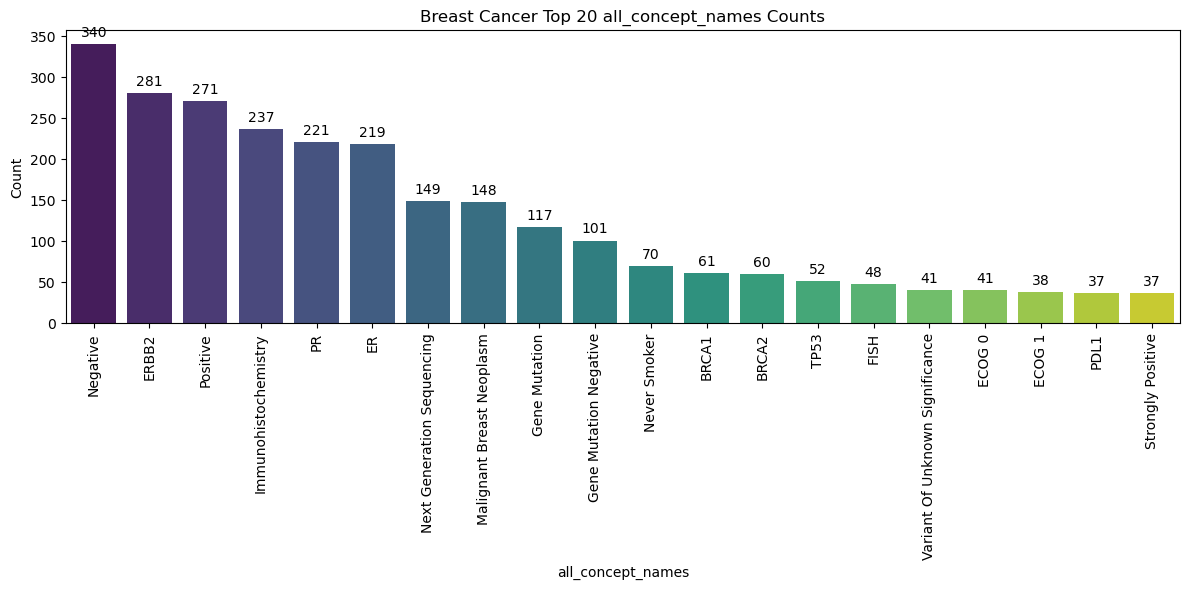

In [291]:
plot_top_concept_counts(breast_mendel_df, 'all_concept_names', top_n=20)

### Results Extraction Comparison

In [194]:
# get dataframe with the same patients to compare extracted results 
import re

def merge_common_df(our_df, filtered_df):
    # Extract patient IDs from file names in our_df
    our_df['patient_id'] = our_df['file_name'].apply(lambda x: re.search(r'[A-Za-z0-9]+', x).group())

    # Filter unique patient IDs from our_df
    unique_patient_ids = our_df['patient_id'].unique()
    unique_our_df = our_df[our_df['patient_id'].isin(unique_patient_ids)]

    # Merge with filtered_df based on customer_patient_id
    merged_df = pd.merge(filtered_df, unique_our_df, left_on='customer_patient_id', right_on='patient_id')
    
    # Drop duplicates based on customer_patient_id
    merged_df = merged_df.drop_duplicates(subset='customer_patient_id', keep = 'first')

    return merged_df

In [298]:
merged_breast_cancer = merge_common_df(breast_our_df, breast_mendel_df)
print(merged_breast_cancer.shape[0])

149


#### Smoking Status

In [268]:
breast_smoking_mendel = breast_mendel_df[breast_mendel_df['event_type'] == 'Smoking Status']
merged_breast_df_smoking = merge_common_df(breast_our_df, breast_smoking_mendel)

In [269]:
print(merged_breast_df_smoking.shape)

(112, 19)


In [270]:
def plot_merged_counts(data, column_name, title):
    plt.figure(figsize=(10, 6))
    unique_values = data[column_name].unique()
    num_unique_values = len(unique_values)
    color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors
    
    ax = data[column_name].value_counts().plot(kind='bar', color=[color_map(i) for i in range(num_unique_values)])
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')
    
    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_71780/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


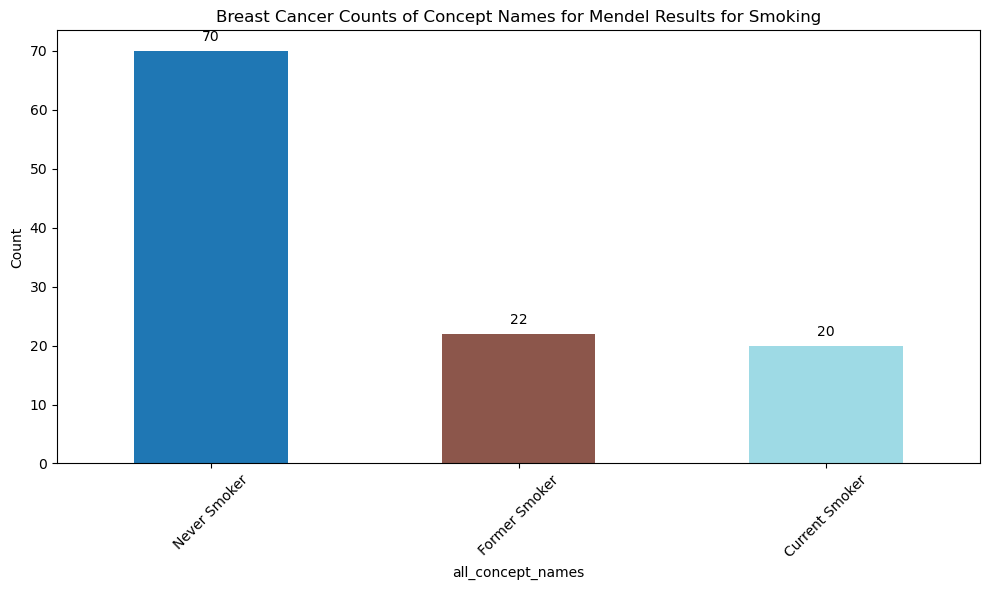

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_71780/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


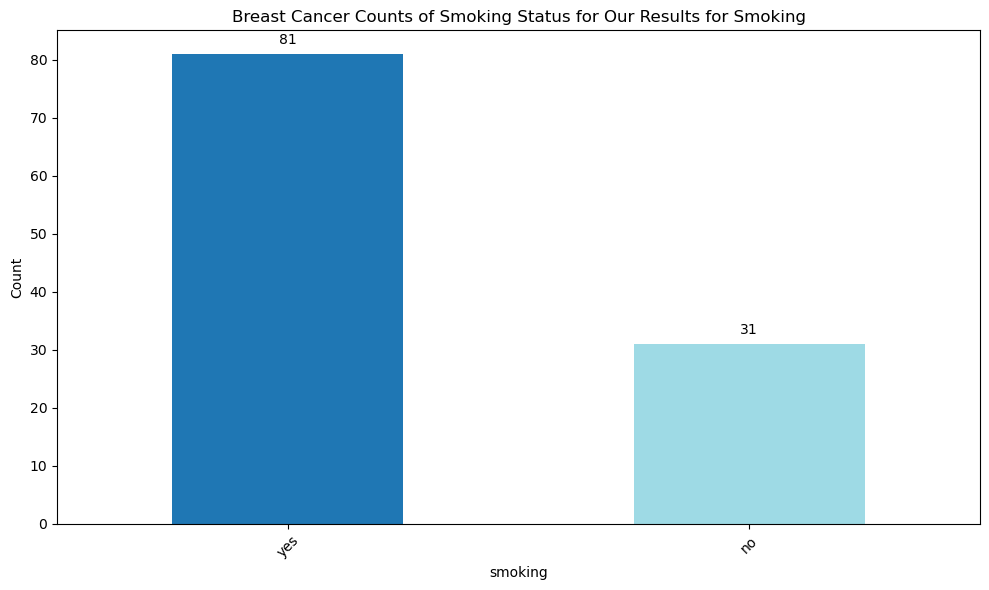

In [285]:
# Plotting counts of 'all_concept_names' for Mendel 
plot_merged_counts(merged_breast_df_smoking, 'all_concept_names', 'Breast Cancer Counts of Concept Names for Mendel Results for Smoking')

# Plotting counts of 'smoking' for our results 
plot_merged_counts(merged_breast_df_smoking, 'smoking', 'Breast Cancer Counts of Smoking Status for Our Results for Smoking')

In [302]:
# entities extraction difference analysis
non_smoker_mendel_df = merged_breast_df_smoking[merged_breast_df_smoking['all_concept_names'] == 'Never Smoker']
actual_text_non_smoker = non_smoker_mendel_df['mention']
# find the negative indicators (excluding the word smoker)
filtered_words = [phrase.replace('smoker', '').strip().lower() for phrase in actual_text_non_smoker]
# Get unique words
unique_words = set(filtered_words)
# Remove any empty strings
unique_words.discard('')
print(unique_words)

{'smoking status: never', 'no', 'smoking status    never', 'never', 'denies any tobacco', 'never used smokeless tobacco', 'does not smoke', 'non', 'never smoker', 'non-', 'nonsmoker', 'no tobacco', 'denies smoking', 'smoking status:\nnever used smokeless tobacco', 'never user', 'smoking status: n', 'never smoked', 'never smoked tobacco', 'smoking status:    never', 'no smoking', 'never\nsmoked', 'has never used:  cigarette. tobacco'}


#### Ecogs

In [259]:
breast_mendel_df.columns

Index(['customer_patient_id', 'event_type', 'confidence_score',
       'property_type', 'property_value_type', 'mention', 'all_concept_names',
       'document_id', 'start_char', 'end_char'],
      dtype='object')

In [260]:
breast_mendel_ecogs = breast_mendel_df[breast_mendel_df['event_type'] == 'ECOG Status']

In [261]:
# get the dataframe with same pateints
merged_breast_df_ecogs = merge_common_df(breast_our_df, breast_mendel_ecogs)

In [262]:
print(merged_breast_df_ecogs.shape)

(93, 19)


In [264]:
mendel_ecogs_counts = merged_breast_df_ecogs['all_concept_names'].count()
print("Number of Mendel ecogs counts: ", mendel_ecogs_counts)

Number of Mendel ecogs counts:  93


In [266]:
non_empty_ecogs_count = merged_breast_df_ecogs['ecogs'].apply(lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0).sum()
print("Number of our non-empty ecogs:", non_empty_ecogs_count)

Number of our non-empty ecogs: 75


/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_71780/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


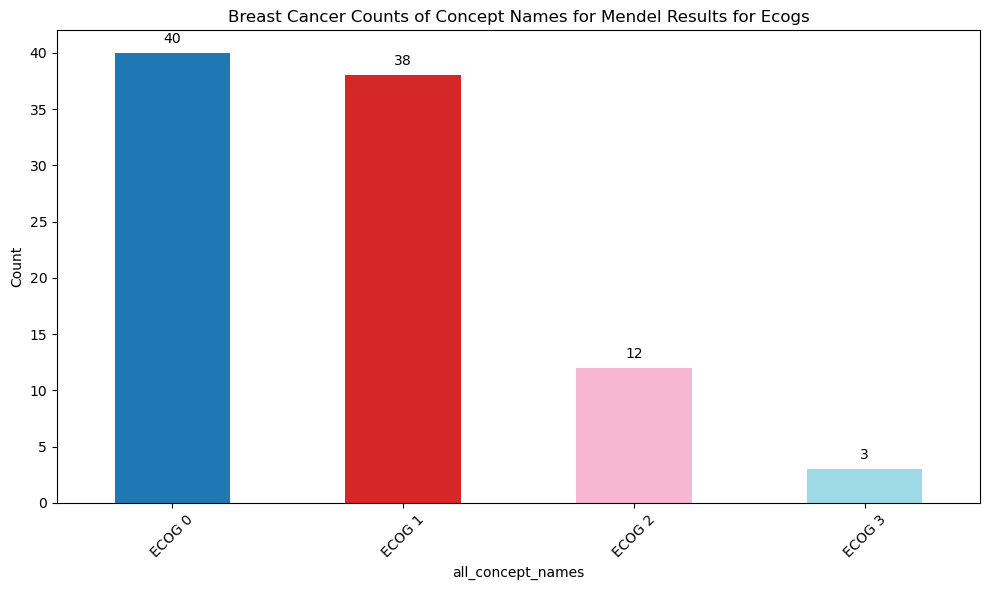

In [286]:
plot_merged_counts(merged_breast_df_ecogs, 'all_concept_names', 'Breast Cancer Counts of Concept Names for Mendel Results for Ecogs')

In [305]:
merged_breast_df_ecogs['mention'][:5]

0                   ECOG 0
1     Performance Status 0
2                   ECOG 0
3                   ECOG 0
4                   ECOG 0
Name: mention, dtype: object

#### Test Results

In [272]:
breast_test_mendel = breast_mendel_df[breast_mendel_df['property_type']=='Biomarker Tested']

In [273]:
merged_breast_df_test = merge_common_df(breast_our_df, breast_test_mendel)

In [274]:
merged_breast_df_test.shape

(145, 19)

In [287]:
def visualize_our_test_results(our_df, title_for_test_counts):
    # Extract 'test_names' and 'test_values' from 'test_results'
    test_data = []
    for test_result in our_df['test_results']:
        for test in test_result:
            test_data.append({
                'test_name': test['test_name'],
                'test_value': test['test_value']
            })

    # Create a new DataFrame
    test_df = pd.DataFrame(test_data)

    # Plot the counts of 'test_names'
    plot_merged_counts(test_df, 'test_name', title_for_test_counts)

    # Plot the counts of 'test_values' for each 'test_name'
    for test_name in test_df['test_name'].unique():
        filtered_df = test_df[test_df['test_name'] == test_name]
        plot_merged_counts(filtered_df, 'test_value', f'Breast Cancer Counts of Test Values for {test_name}')


/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_71780/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


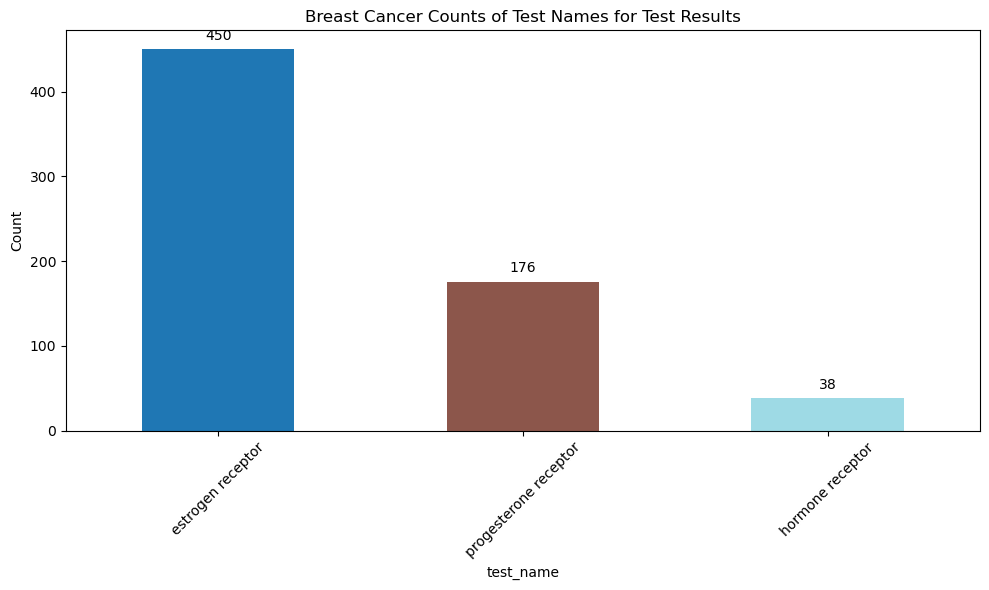

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_71780/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


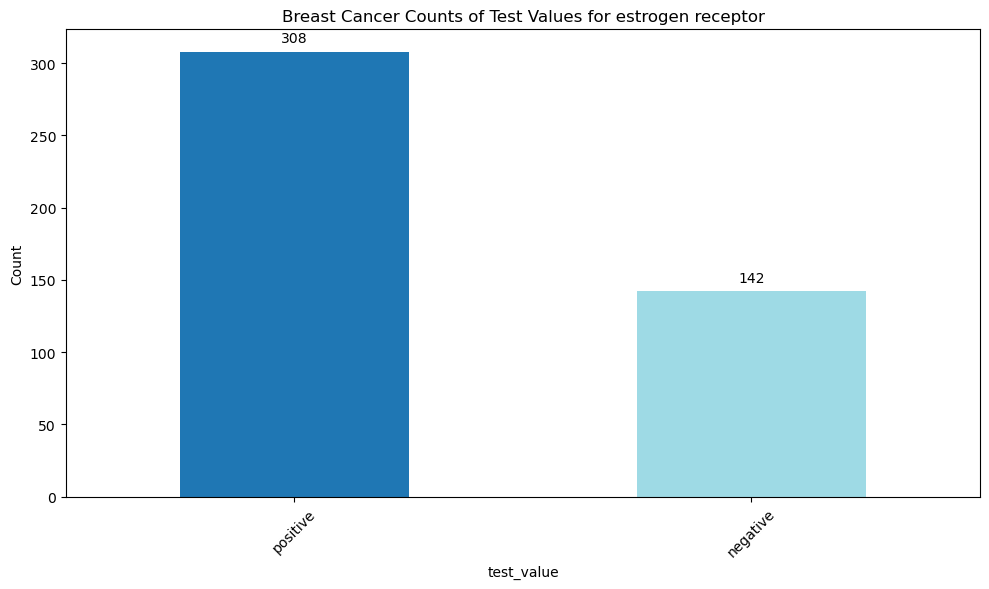

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_71780/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


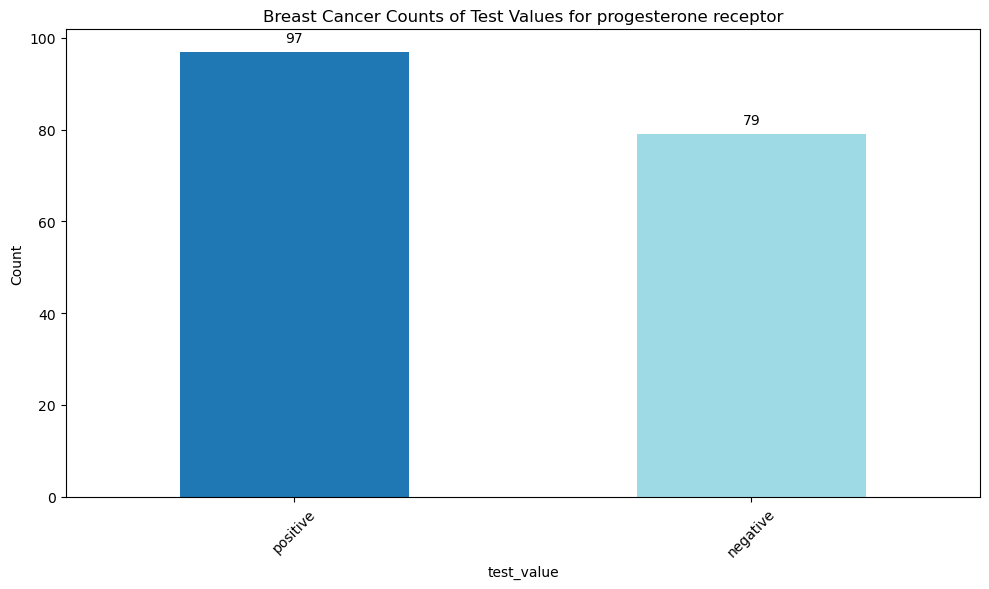

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_71780/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


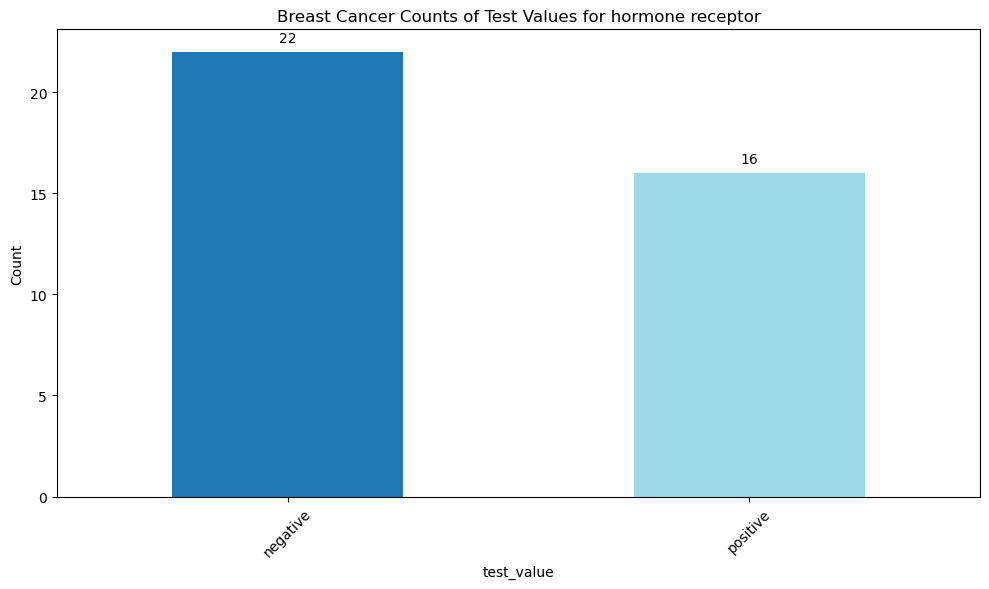

In [288]:
# our test results 
title_our_test_counts = 'Breast Cancer Counts of Test Names for Test Results'
visualize_our_test_results(merged_breast_df_test, title_our_test_counts)

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_71780/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


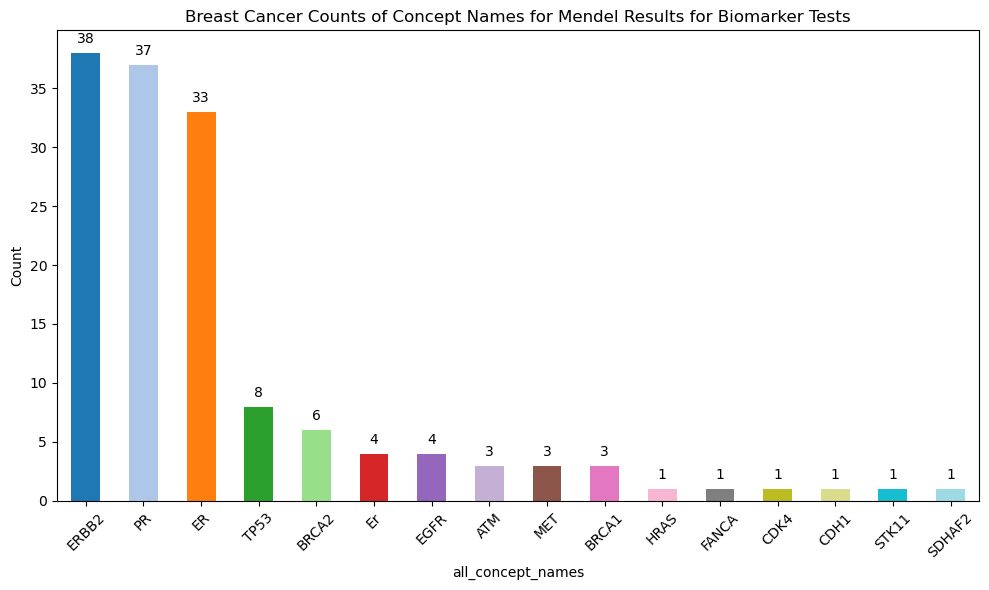

In [289]:
# mendel results 
plot_merged_counts(merged_breast_df_test, 'all_concept_names', 'Breast Cancer Counts of Concept Names for Mendel Results for Biomarker Tests')

In [307]:
merged_breast_df_test['mention'][:6]

0                   TP53
9                     PR
14    Estrogen receptor 
25                   ER 
30                  1753
45              estrogen
Name: mention, dtype: object

#### Important Dates

In [278]:
# Date of Result
breast_date_mendel = breast_mendel_df[breast_mendel_df['property_type']=='Date of Result']

In [292]:
merged_breast_df_dates = merge_common_df(breast_our_df, breast_date_mendel)

In [293]:
merged_breast_df_dates.columns

Index(['customer_patient_id', 'event_type', 'confidence_score',
       'property_type', 'property_value_type', 'mention', 'all_concept_names',
       'document_id', 'start_char', 'end_char', 'file_name', 'dates',
       'important dates', 'diseases', 'smoking', 'smoking_keyword', 'ecogs',
       'test_results', 'patient_id'],
      dtype='object')

In [297]:
merged_breast_df_dates.shape

(72, 19)

In [296]:
print("Number of results dates extracted by Mendel: ", len(merged_breast_df_dates['mention']))

Number of results dates extracted by Mendel:  72


In [295]:
non_empty_important_dates_count = merged_breast_df_dates['important dates'].apply(lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0).sum()
print("Number of our non-empty important dates:", non_empty_important_dates_count)

Number of our non-empty important dates: 54


In [308]:
merged_breast_df_dates['mention'][:4]

0       OCT-11-2022
7       08/25/2020 
17       10/14/2022
20      OCT-20-2022
Name: mention, dtype: object

In [309]:
merged_breast_df_dates.head()

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char,file_name,dates,important dates,diseases,smoking,smoking_keyword,ecogs,test_results,patient_id
0,A0586396,Biomarker,0.448987,Date of Result,String,OCT-11-2022,None,doc-01h5dxcjq4fnkcba9d3zh4zj5x,297.0,308.0,A0586396_MedRec1.txt,"[{'start': 19463, 'end': 19473, 'text': '10/14...",[{'keyword': 'received zometa today which was ...,"[{'start': 309, 'end': 338, 'text': 'breast ca...",yes,smoking,"[{'start': 9612, 'end': 9630, 'text': 'perform...","[{'test_name': 'estrogen receptor', 'test_valu...",A0586396
7,A0597108,Biomarker,NaN,Date of Result,String,08/25/2020,None,doc-01h5dw7y6hxd0s18mwy3mcr1me,658.0,669.0,A0597108_MedRec1.txt,"[{'start': 35, 'end': 45, 'text': '10/17/2022'...",[{'keyword': 'collection date: 9/17/2022 16:50...,"[{'start': 327, 'end': 336, 'text': 'tennessee...",no,,"[{'start': 18395, 'end': 18406, 'text': 'perfo...","[{'test_name': 'estrogen receptor', 'test_valu...",A0597108
17,A0591594,Biomarker,NaN,Date of Result,String,10/14/2022,None,doc-01h5dw7xv78mshtbj2c7ekrqk8,639.0,649.0,A0591594_MedRec1.txt,"[{'start': 1002, 'end': 1012, 'text': '09/19/2...","[{'keyword': 'collected:', 'start': 40377, 'en...","[{'start': 288, 'end': 304, 'text': 'birth: 2/...",yes,smoker,"[{'start': 8479, 'end': 8490, 'text': 'perform...","[{'test_name': 'estrogen receptor', 'test_valu...",A0591594
20,A0595176,Biomarker,NaN,Date of Result,String,OCT-20-2022,None,doc-01h5dwt8bprf70km3as5ms5dm8,820.0,833.0,A0595176_MedRec1.txt,"[{'start': 175, 'end': 185, 'text': '11/18/202...","[{'keyword': 'collected by oe pod, cee jo. see...","[{'start': 603, 'end': 626, 'text': 'breast ca...",yes,smoking,"[{'start': 9284, 'end': 9295, 'text': 'perform...","[{'test_name': 'estrogen receptor', 'test_valu...",A0595176
32,A0595789,Biomarker,0.618704,Date of Result,String,04/25/2020,None,doc-01h5dxcjrf4dnhe7y4s26847dj,3565.0,3575.0,A0595789_MedRec1.txt,"[{'start': 208, 'end': 218, 'text': '10/31/202...",[{'keyword': 'received date/time: 202210312012...,"[{'start': 26, 'end': 42, 'text': 'tennessee c...",yes,smoker,"[{'start': 22643, 'end': 22661, 'text': 'perfo...","[{'test_name': 'estrogen receptor', 'test_valu...",A0595789
